In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

data = pd.read_csv('AMZN.csv')

data

,Date,Open,High,Low,Close,Adj Close,Volume
0,1997-05-15,0.121875,0.125000,0.096354,0.097917,0.097917,1443120000
1,1997-05-16,0.098438,0.098958,0.085417,0.086458,0.086458,294000000
2,1997-05-19,0.088021,0.088542,0.081250,0.085417,0.085417,122136000
3,1997-05-20,0.086458,0.087500,0.081771,0.081771,0.081771,109344000
4,1997-05-21,0.081771,0.082292,0.068750,0.071354,0.071354,377064000
...,...,...,...,...,...,...,...
6787,2024-05-06,186.279999,188.750000,184.800003,188.699997,188.699997,34725300
6788,2024-05-07,188.919998,189.940002,187.309998,188.759995,188.759995,34048900
6789,2024-05-08,187.440002,188.429993,186.389999,188.000000,188.000000,26136400
6790,2024-05-09,188.880005,191.699997,187.440002,189.500000,189.500000,43368400


In [2]:
data = data[['Date', 'Close']]
data

,Date,Close
0,1997-05-15,0.097917
1,1997-05-16,0.086458
2,1997-05-19,0.085417
3,1997-05-20,0.081771
4,1997-05-21,0.071354
...,...,...
6787,2024-05-06,188.699997
6788,2024-05-07,188.759995
6789,2024-05-08,188.000000
6790,2024-05-09,189.500000


In [3]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device

'cuda:0'

<ipython-input-4-27440ea654b2>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = pd.to_datetime(data['Date'])


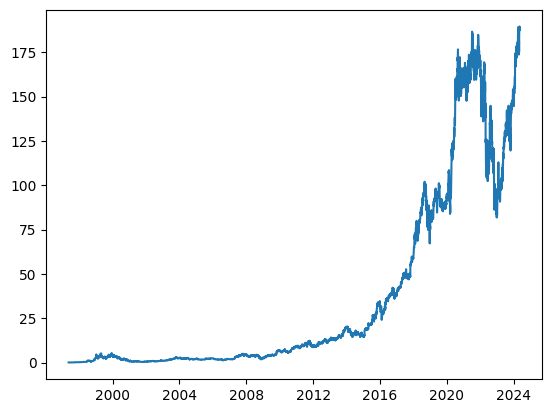

In [4]:
data['Date'] = pd.to_datetime(data['Date'])

plt.plot(data['Date'], data['Close'])

In [5]:
from copy import deepcopy as dc

def prepare_dataframe_for_lstm(df, n_steps):
    df = dc(df)

    df.set_index('Date', inplace=True)

    for i in range(1, n_steps+1):
        df[f'Close(t-{i})'] = df['Close'].shift(i)

    df.dropna(inplace=True)

    return df

lookback = 7
shifted_df = prepare_dataframe_for_lstm(data, lookback)
shifted_df

,Close,Close(t-1),Close(t-2),Close(t-3),Close(t-4),Close(t-5),Close(t-6),Close(t-7)
Date,,,,,,,,
1997-05-27,0.079167,0.075000,0.069792,0.071354,0.081771,0.085417,0.086458,0.097917
1997-05-28,0.076563,0.079167,0.075000,0.069792,0.071354,0.081771,0.085417,0.086458
1997-05-29,0.075260,0.076563,0.079167,0.075000,0.069792,0.071354,0.081771,0.085417
1997-05-30,0.075000,0.075260,0.076563,0.079167,0.075000,0.069792,0.071354,0.081771
1997-06-02,0.075521,0.075000,0.075260,0.076563,0.079167,0.075000,0.069792,0.071354
...,...,...,...,...,...,...,...,...
2024-05-06,188.699997,186.210007,184.720001,179.000000,175.000000,180.960007,179.619995,173.669998
2024-05-07,188.759995,188.699997,186.210007,184.720001,179.000000,175.000000,180.960007,179.619995
2024-05-08,188.000000,188.759995,188.699997,186.210007,184.720001,179.000000,175.000000,180.960007


In [6]:
shifted_df_as_np = shifted_df.to_numpy()

shifted_df_as_np

array([[7.91670000e-02, 7.50000000e-02, 6.97920000e-02, ...,
        8.54170000e-02, 8.64580000e-02, 9.79170000e-02],
       [7.65630000e-02, 7.91670000e-02, 7.50000000e-02, ...,
        8.17710000e-02, 8.54170000e-02, 8.64580000e-02],
       [7.52600000e-02, 7.65630000e-02, 7.91670000e-02, ...,
        7.13540000e-02, 8.17710000e-02, 8.54170000e-02],
       ...,
       [1.88000000e+02, 1.88759995e+02, 1.88699997e+02, ...,
        1.79000000e+02, 1.75000000e+02, 1.80960007e+02],
       [1.89500000e+02, 1.88000000e+02, 1.88759995e+02, ...,
        1.84720001e+02, 1.79000000e+02, 1.75000000e+02],
       [1.87479996e+02, 1.89500000e+02, 1.88000000e+02, ...,
        1.86210007e+02, 1.84720001e+02, 1.79000000e+02]])

In [7]:
shifted_df_as_np.shape

(6785, 8)

In [8]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1))
shifted_df_as_np = scaler.fit_transform(shifted_df_as_np)

shifted_df_as_np

array([[-0.99991201, -0.999956  , -1.        , ..., -0.99983464,
        -0.99982362, -0.99970235],
       [-0.9999395 , -0.99991201, -0.99994488, ..., -0.99987322,
        -0.99983464, -0.99982362],
       [-0.99995326, -0.9999395 , -0.99990078, ..., -0.99998347,
        -0.99987322, -0.99983464],
       ...,
       [ 0.98416295,  0.992187  ,  0.99629584, ...,  0.89363963,
         0.85130715,  0.91438261],
       [ 1.        ,  0.98416295,  0.99693081, ...,  0.95417507,
         0.89363963,  0.85130715],
       [ 0.97867272,  1.        ,  0.98888769, ...,  0.96994399,
         0.95417507,  0.89363963]])

In [9]:
X = shifted_df_as_np[:, 1:]
y = shifted_df_as_np[:, 0]

X.shape, y.shape

((6785, 7), (6785,))

In [10]:
X = dc(np.flip(X, axis=1))
X

array([[-0.99970235, -0.99982362, -0.99983464, ..., -0.99998347,
        -1.        , -0.999956  ],
       [-0.99982362, -0.99983464, -0.99987322, ..., -1.        ,
        -0.99994488, -0.99991201],
       [-0.99983464, -0.99987322, -0.99998347, ..., -0.99994488,
        -0.99990078, -0.9999395 ],
       ...,
       [ 0.91438261,  0.85130715,  0.89363963, ...,  0.96994399,
         0.99629584,  0.992187  ],
       [ 0.85130715,  0.89363963,  0.95417507, ...,  0.99629584,
         0.99693081,  0.98416295],
       [ 0.89363963,  0.95417507,  0.96994399, ...,  0.99693081,
         0.98888769,  1.        ]])

In [11]:
split_index = int(len(X) * 0.95)

split_index

6445

In [12]:
X_train = X[:split_index]
X_test = X[split_index:]

y_train = y[:split_index]
y_test = y[split_index:]

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((6445, 7), (340, 7), (6445,), (340,))

In [13]:
X_train = X_train.reshape((-1, lookback, 1))
X_test = X_test.reshape((-1, lookback, 1))

y_train = y_train.reshape((-1, 1))
y_test = y_test.reshape((-1, 1))

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((6445, 7, 1), (340, 7, 1), (6445, 1), (340, 1))

In [14]:
X_train = torch.tensor(X_train).float()
y_train = torch.tensor(y_train).float()
X_test = torch.tensor(X_test).float()
y_test = torch.tensor(y_test).float()

X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([6445, 7, 1]),
 torch.Size([340, 7, 1]),
 torch.Size([6445, 1]),
 torch.Size([340, 1]))

In [15]:
from torch.utils.data import Dataset

class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, i):
        return self.X[i], self.y[i]

train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_test, y_test)

In [16]:
train_dataset

In [17]:
from torch.utils.data import DataLoader

batch_size = 16

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [18]:
for _, batch in enumerate(train_loader):
    x_batch, y_batch = batch[0].to(device), batch[1].to(device)
    print(x_batch.shape, y_batch.shape)
    break

torch.Size([16, 7, 1]) torch.Size([16, 1])


In [19]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_stacked_layers):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_stacked_layers = num_stacked_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_stacked_layers,
                            batch_first=True)

        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        c0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)

        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

model = LSTM(1, 4, 1)
model.to(device)
model

LSTM(
  (lstm): LSTM(1, 4, batch_first=True)
  (fc): Linear(in_features=4, out_features=1, bias=True)
)

In [20]:
def train_one_epoch():
    model.train(True)
    print(f'Epoch: {epoch + 1}')
    running_loss = 0.0

    for batch_index, batch in enumerate(train_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)

        output = model(x_batch)
        loss = loss_function(output, y_batch)
        running_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_index % 100 == 99:  # print every 100 batches
            avg_loss_across_batches = running_loss / 100
            print('Batch {0}, Loss: {1:.3f}'.format(batch_index+1,
                                                    avg_loss_across_batches))
            running_loss = 0.0
    print()

In [21]:
def validate_one_epoch():
    model.train(False)
    running_loss = 0.0

    for batch_index, batch in enumerate(test_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)

        with torch.no_grad():
            output = model(x_batch)
            loss = loss_function(output, y_batch)
            running_loss += loss.item()

    avg_loss_across_batches = running_loss / len(test_loader)

    print('Val Loss: {0:.3f}'.format(avg_loss_across_batches))
    print('***************************************************')
    print()

In [22]:
learning_rate = 0.001
num_epochs = 10
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    train_one_epoch()
    validate_one_epoch()

Epoch: 1
Batch 100, Loss: 0.185
Batch 200, Loss: 0.086
Batch 300, Loss: 0.011
Batch 400, Loss: 0.007

Val Loss: 0.026
***************************************************

Epoch: 2
Batch 100, Loss: 0.004
Batch 200, Loss: 0.004
Batch 300, Loss: 0.003
Batch 400, Loss: 0.002

Val Loss: 0.010
***************************************************

Epoch: 3
Batch 100, Loss: 0.002
Batch 200, Loss: 0.001
Batch 300, Loss: 0.001
Batch 400, Loss: 0.001

Val Loss: 0.004
***************************************************

Epoch: 4
Batch 100, Loss: 0.001
Batch 200, Loss: 0.001
Batch 300, Loss: 0.000
Batch 400, Loss: 0.000

Val Loss: 0.002
***************************************************

Epoch: 5
Batch 100, Loss: 0.000
Batch 200, Loss: 0.000
Batch 300, Loss: 0.000
Batch 400, Loss: 0.000

Val Loss: 0.002
***************************************************

Epoch: 6
Batch 100, Loss: 0.000
Batch 200, Loss: 0.000
Batch 300, Loss: 0.000
Batch 400, Loss: 0.000

Val Loss: 0.002
***************************

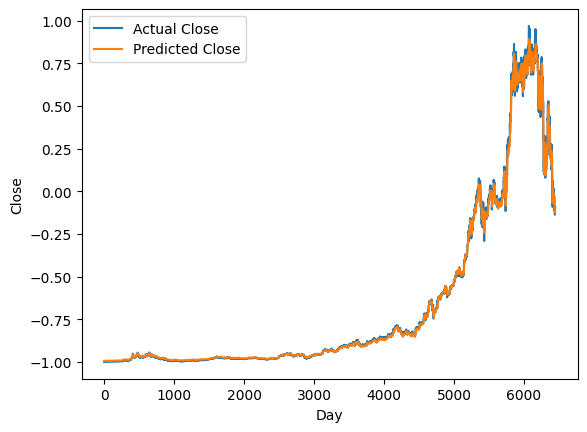

In [23]:
with torch.no_grad():
    predicted = model(X_train.to(device)).to('cpu').numpy()

plt.plot(y_train, label='Actual Close')
plt.plot(predicted, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()


In [24]:
train_predictions = predicted.flatten()

dummies = np.zeros((X_train.shape[0], lookback+1))
dummies[:, 0] = train_predictions
dummies = scaler.inverse_transform(dummies)

train_predictions = dc(dummies[:, 0])
train_predictions

array([ 0.65470586,  0.65402841,  0.65342999, ..., 83.07022243,
       83.02542878, 83.00769648])

In [25]:
dummies = np.zeros((X_train.shape[0], lookback+1))
dummies[:, 0] = y_train.flatten()
dummies = scaler.inverse_transform(dummies)

new_y_train = dc(dummies[:, 0])
new_y_train

array([7.91656534e-02, 7.65631105e-02, 7.52590164e-02, ...,
       8.41800002e+01, 8.39999999e+01, 8.58200002e+01])

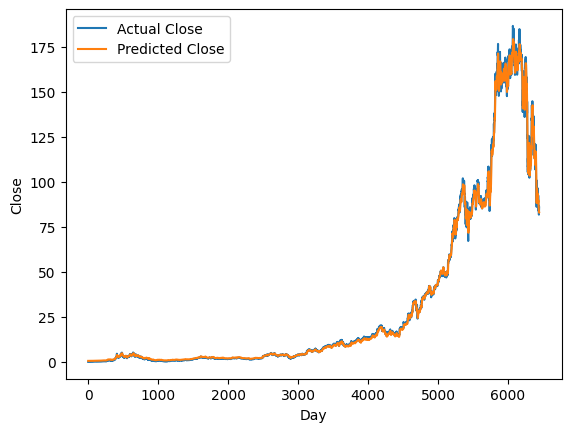

In [26]:
plt.plot(new_y_train, label='Actual Close')
plt.plot(train_predictions, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()


In [27]:
test_predictions = model(X_test.to(device)).detach().cpu().numpy().flatten()

dummies = np.zeros((X_test.shape[0], lookback+1))
dummies[:, 0] = test_predictions
dummies = scaler.inverse_transform(dummies)

test_predictions = dc(dummies[:, 0])
test_predictions

array([ 83.5191272 ,  83.83881656,  83.58273425,  84.084675  ,
        84.80721088,  86.02585297,  88.39872844,  90.43049015,
        92.73188037,  93.8438803 ,  94.29243223,  93.93159051,
        94.37641645,  94.81174396,  94.85810705,  95.13821912,
        95.91807023,  97.35405569,  98.03492832,  99.19181223,
       100.64208909, 103.853785  , 103.82634822, 103.12007116,
       102.34755629, 101.03192291,  99.42798311,  98.02577143,
        97.62880744,  97.56899412,  98.02279629,  97.7011649 ,
        97.16186835,  95.98557545,  95.28342521,  94.77585032,
        93.85279726,  93.26455201,  93.0137877 ,  92.3520305 ,
        91.8125787 ,  92.13950267,  92.2163906 ,  92.24384714,
        92.36644046,  92.03873741,  91.32661734,  91.13917215,
        91.67903889,  92.56091984,  94.35782605,  95.59766955,
        96.15526011,  97.17189463,  97.35716632,  97.35777039,
        97.12421334,  96.8983623 ,  96.50958983,  96.97565387,
        97.91885265,  99.09469956,  99.81677252, 100.72

In [28]:
dummies = np.zeros((X_test.shape[0], lookback+1))
dummies[:, 0] = y_test.flatten()
dummies = scaler.inverse_transform(dummies)

new_y_test = dc(dummies[:, 0])
new_y_test

array([ 85.13999905,  83.12000312,  86.08000181,  87.36000124,
        89.87000313,  95.089996  ,  95.26999698,  98.12000317,
        96.05000303,  95.45999901,  93.68000002,  97.25000003,
        97.51999708,  96.32000009,  97.18000006,  99.22000092,
       102.23999816, 100.55000297, 103.12999724, 105.15000234,
       112.91000454, 103.38999889, 102.17999995, 102.11000087,
       100.05000284,  98.23999817,  97.61000092,  99.54000113,
        99.69999717, 101.16000429,  98.15000192,  97.19999705,
        94.580002  ,  95.79000103,  95.82000004,  93.50000001,
        93.76000202,  94.230003  ,  92.16999805,  92.12999701,
        94.900002  ,  93.74999999,  93.55000299,  93.91999798,
        92.24999995,  90.7300031 ,  92.43000005,  94.879997  ,
        96.19999696, 100.0400009 ,  98.94999698,  97.70999894,
       100.61000083,  98.69999691,  98.70999885,  98.12999699,
        98.04000109,  97.23999791, 100.24999993, 101.99999968,
       103.2900007 , 102.41000391, 103.94999723, 101.09

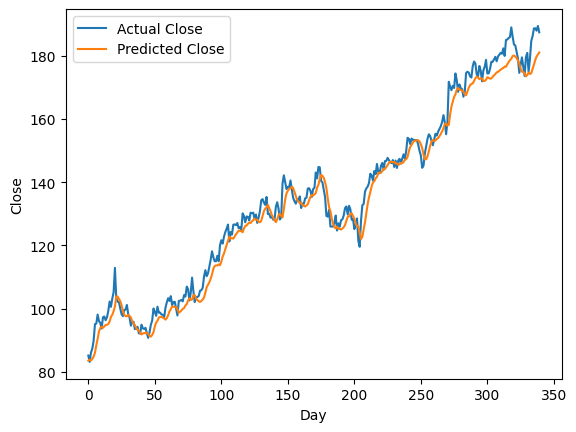

In [29]:
plt.plot(new_y_test, label='Actual Close')
plt.plot(test_predictions, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()
